In [2]:
#importing required python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data with a sample size (working with the full dataset is too slow)
# Stratified sample by CASE_TYPE for accurate representation
Ops_Data = pd.read_csv('ops_data/operational_analyst_data.csv').groupby('CASE_TYPE', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=1))
print(Ops_Data.shape)

# Display the first few rows and summary information to understand the dataset

Ops_Data.head(10), Ops_Data.info(10)

(47332, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47332 entries, 31006 to 448087
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CASE_ID              47332 non-null  int64  
 1   HANDLING_TIME_START  47332 non-null  object 
 2   HANDLING_TIME_END    47332 non-null  object 
 3   ACTOR_ID             47332 non-null  int64  
 4   OPS_DECISION         47332 non-null  object 
 5   CUSTOMER_ID          47332 non-null  int64  
 6   CASE_TYPE            47332 non-null  object 
 7   FINAL_STATE          47332 non-null  object 
 8   PROCESSING_ID        47332 non-null  int64  
 9   CASE_CREATED_TIME    47332 non-null  object 
 10  Unnamed: 10          0 non-null      float64
dtypes: float64(1), int64(4), object(6)
memory usage: 4.3+ MB


(        CASE_ID HANDLING_TIME_START HANDLING_TIME_END  ACTOR_ID  \
 31006     31017    26-11-2021 14:15  26-11-2021 14:16      1241   
 38284     38296    30-11-2021 14:08  30-11-2021 14:15     23568   
 205474   205532    09-02-2022 18:27  09-02-2022 18:28       819   
 302353   302425    14-03-2022 05:58  14-03-2022 05:59       465   
 208319   208376    11-02-2022 14:01  11-02-2022 14:04     56686   
 49498     49512    06-12-2021 05:24  06-12-2021 05:27       455   
 230830   230888    18-02-2022 11:49  18-02-2022 11:51       819   
 197297   197352    06-02-2022 23:43  06-02-2022 23:45       465   
 27659     27667    26-11-2021 01:22  26-11-2021 01:22       465   
 71156     71174    15-12-2021 12:28  15-12-2021 12:29       608   
 
             OPS_DECISION  CUSTOMER_ID CASE_TYPE FINAL_STATE  PROCESSING_ID  \
 31006          OPS_CLOSE        31061  TYPE_ONE      CLOSED          31167   
 38284          OPS_CLOSE        38340  TYPE_ONE      CLOSED          38446   
 205474      

> Stratified Sampling Approach:
    -Grouped By CASE_TYPE: Ensures balanced representation across case types.
    -Sampled 10% from Each Group: Allows efficient processing without compromising accuracy.

> Benefits:
    -Representation: Reflects the true distribution of each case type in the dataset.
    -Performance Optimization: Reduces data size, making analysis more manageable and efficient. 

## Initial Data Cleaning 

In [4]:
#checking duplicate values if any
Ops_Data[Ops_Data.duplicated()]

,CASE_ID,HANDLING_TIME_START,HANDLING_TIME_END,ACTOR_ID,OPS_DECISION,CUSTOMER_ID,CASE_TYPE,FINAL_STATE,PROCESSING_ID,CASE_CREATED_TIME,Unnamed: 10
458589,458717,06-05-2022 09:31,06-05-2022 09:31,258423,OPS_UNASSIGN,458615,TYPE_THREE,APPROVED,458867,06-05-2022 09:31,NaN


The output from Ops_Data[Ops_Data.duplicated()] shows a single duplicate row where all column values are identical across the entire row. This indicates an exact duplicate that likely results from a data entry or merging error, rather than a meaningful review record.

In [5]:
# Remove exact duplicates across all columns
Ops_Data = Ops_Data.drop_duplicates()

In [6]:
# Check for missing values
Ops_Data.isnull().sum()

# Convert handling time (date columns) to datetime format
Ops_Data['CASE_CREATED_TIME'] = pd.to_datetime(Ops_Data['CASE_CREATED_TIME'], errors='coerce')
Ops_Data['HANDLING_TIME_START'] = pd.to_datetime(Ops_Data['HANDLING_TIME_START'], errors='coerce')
Ops_Data['HANDLING_TIME_END'] = pd.to_datetime(Ops_Data['HANDLING_TIME_END'], errors='coerce')

# Calculating handling time in seconds
Ops_Data['HANDLING_TIME'] = (Ops_Data['HANDLING_TIME_END'] - Ops_Data['HANDLING_TIME_START']).dt.total_seconds()

# Filtering out negative handling times (if any)
Ops_Data = Ops_Data[Ops_Data['HANDLING_TIME'] >= 0]

## 1. Operational health of the processing team

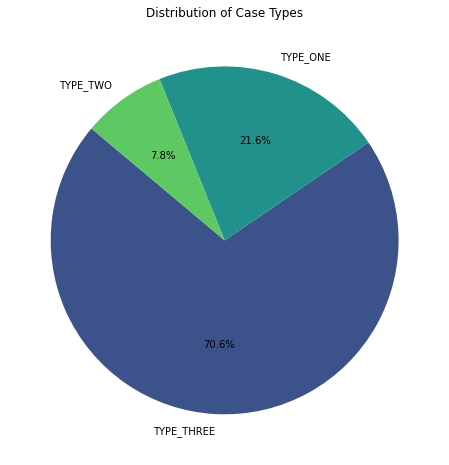

In [7]:
#Loading full Operational data of 6 months
operational_analyst_data = pd.read_csv('ops_data/operational_analyst_data.csv')

# Calculate the counts for each CASE_TYPE
case_type_counts = operational_analyst_data['CASE_TYPE'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(case_type_counts, labels=case_type_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette("viridis", len(case_type_counts)))
plt.title('Distribution of Case Types')
plt.show()

PIE Chart Interpretation: Majority of cases fall under TYPE_ONE. The analysis focuses on TYPE_THREE cases,
given the high complexity and workload demands identified in subsequent slides. 

### 1.1 Calculating Processing Time Metrics

In [8]:
# Average handling time per case type
# Average Handling Time by Case Type: The mean handling time for each case type is calculated to understand the average time needed for different types of cases.
avg_handling_time_case_type = Ops_Data.groupby('CASE_TYPE')['HANDLING_TIME'].mean()
print("Average Handling Time per Case Type:")
print(avg_handling_time_case_type)

# Total handling time per associate
# Total Handling Time per Associate: Sums up the total handling time each associate has worked on, giving insight into workload distribution across the team.
total_handling_time_per_associate = Ops_Data.groupby('ACTOR_ID')['HANDLING_TIME'].sum()
print("\nTotal Handling Time per Associate:")
print(total_handling_time_per_associate[:5])

# Handling time variation per case type
# Handling Time Variation: Provides statistical insights (mean, standard deviation, min, max) to assess how consistent handling times are within each case type.
handling_time_variation = Ops_Data.groupby('CASE_TYPE')['HANDLING_TIME'].agg(['mean', 'std', 'min', 'max'])
print("\nHandling Time Variation per Case Type:")
print(handling_time_variation)

Average Handling Time per Case Type:
CASE_TYPE
TYPE_ONE      382.469184
TYPE_THREE    865.923289
TYPE_TWO      863.306189
Name: HANDLING_TIME, dtype: float64

Total Handling Time per Associate:
ACTOR_ID
451    496320.0
455     85020.0
458    110160.0
461     85140.0
462    189300.0
Name: HANDLING_TIME, dtype: float64

Handling Time Variation per Case Type:
                  mean           std  min        max
CASE_TYPE                                           
TYPE_ONE    382.469184  25637.599322  0.0  2592120.0
TYPE_THREE  865.923289  34525.006662  0.0  2660520.0
TYPE_TWO    863.306189  41280.167328  0.0  2505660.0


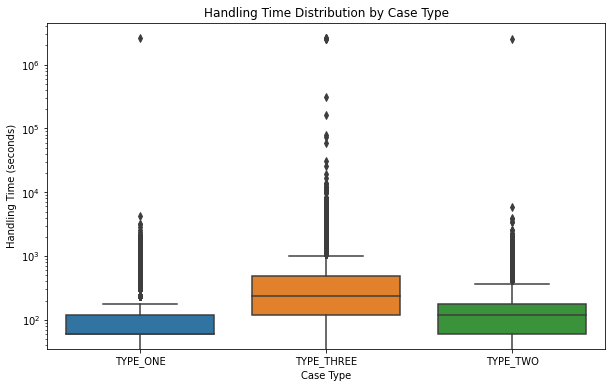

In [9]:
# Visualization: Handling time distribution per case type
# Visualization: A boxplot displays the handling time distribution by case type, making it easy to identify outliers and time variance.
plt.figure(figsize=(10, 6))
sns.boxplot(x="CASE_TYPE", y="HANDLING_TIME", data=Ops_Data)
plt.title("Handling Time Distribution by Case Type")
plt.xlabel("Case Type")
plt.ylabel("Handling Time (seconds)")
plt.yscale('log')  # Log scale for better visualization of variance
plt.show()

### 1.2 Calculating Throughput and Workload Balance

In [10]:
# Number of cases handled per associate
#Cases Handled per Associate: Counts unique cases per associate, allowing us to check if work is evenly distributed.
cases_per_associate = Ops_Data.groupby('ACTOR_ID')['CASE_ID'].nunique()
print("\nCases Handled per Associate:")
print(cases_per_associate[:5])

# Check for workload balance using distribution statistics
#Workload Distribution: Descriptive statistics (mean, median, etc.) summarize workload balance, while a histogram visualizes how evenly cases are spread across associates.
workload_distribution = cases_per_associate.describe()
print("\nWorkload Distribution Among Associates:")
print(workload_distribution)


Cases Handled per Associate:
ACTOR_ID
451    1744
455     783
458     315
461     434
462     484
Name: CASE_ID, dtype: int64

Workload Distribution Among Associates:
count     318.000000
mean      146.440252
std       218.255749
min         1.000000
25%        17.000000
50%        67.000000
75%       190.750000
max      1744.000000
Name: CASE_ID, dtype: float64


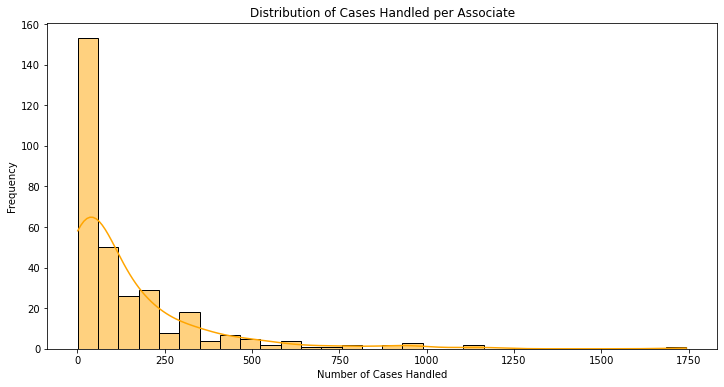

In [11]:
# Visualization: Workload per associate
plt.figure(figsize=(12, 6))
sns.histplot(cases_per_associate, bins=30, kde=True, color="orange")
plt.title("Distribution of Cases Handled per Associate")
plt.xlabel("Number of Cases Handled")
plt.ylabel("Frequency")
plt.show()

### 1.3 Calculating Decision Consistency across various Ops_Decision

In [13]:
# Frequency and distribution of OPS_DECISION values
# Decision Frequency: Calculates the frequency of each OPS_DECISION, showing if certain decisions dominate, which may suggest a need for clearer guidelines or more training.
decision_frequency = Ops_Data['OPS_DECISION'].value_counts(normalize=True)
print("\nDecision Distribution (Frequency of OPS_DECISION Values):")
print(decision_frequency)


Decision Distribution (Frequency of OPS_DECISION Values):
OPS_WAITING                     0.429960
OPS_APPROVE                     0.268139
OPS_CLOSE                       0.116269
OPS_NO_REVIEW_NEEDED            0.068223
OPS_UNASSIGN                    0.041432
OPS_REVIEW_PAUSE                0.036679
OPS_VERIFICATION_TEAM_CHANGE    0.031692
OPS_REJECT                      0.007606
Name: OPS_DECISION, dtype: float64


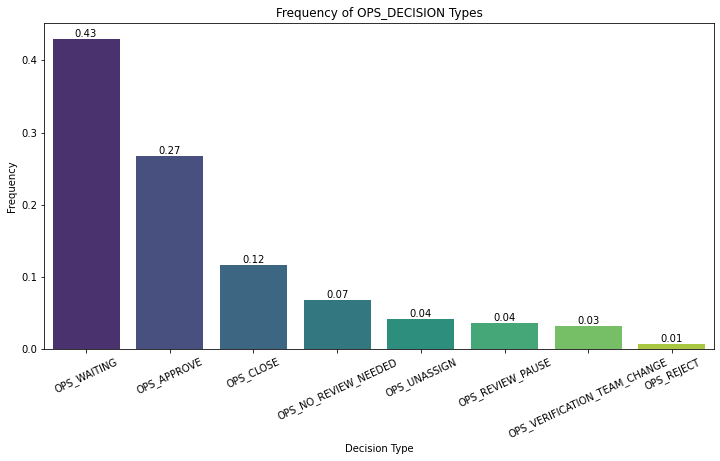

In [14]:
# Visualization: Decision consistency
# Visualization: A count plot of OPS_DECISION shows the most frequent outcomes, providing insight into decision-making consistency.
plt.figure(figsize=(12, 6))
sns.barplot(x=decision_frequency.index, y=decision_frequency.values, palette="viridis")

# Add the frequency values on top of each bar
for index, value in enumerate(decision_frequency.values):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='black')
    
plt.title('Frequency of OPS_DECISION Types')
plt.xlabel('Decision Type')
plt.ylabel('Frequency')
plt.xticks(rotation=25)
plt.show()

Explanation of Each Step
Loading Data: I loaded a stratified random sample (10% of each CASE_TYPE) for efficiency, especially given the large dataset size.

1. Processing Time Metrics:

Average Handling Time by Case Type: The mean handling time for each case type is calculated to understand the average time needed for different types of cases.
Total Handling Time per Associate: Sums up the total handling time each associate has worked on, giving insight into workload distribution across the team.
Handling Time Variation: Provides statistical insights (mean, standard deviation, min, max) to assess how consistent handling times are within each case type.
Visualization: A boxplot displays the handling time distribution by case type, making it easy to identify outliers and time variance.

2. Throughput and Workload Balance:

Cases Handled per Associate: Counts unique cases per associate, allowing us to check if work is evenly distributed.
Workload Distribution: Descriptive statistics (mean, median, etc.) summarize workload balance, while a histogram visualizes how evenly cases are spread across associates.

3. Decision Consistency:

Decision Frequency: Calculates the frequency of each OPS_DECISION, showing if certain decisions dominate, which may suggest a need for clearer guidelines or more training.
Visualization: A count plot of OPS_DECISION shows the most frequent outcomes, providing insight into decision-making consistency.

4. How This Addresses the Operational Health Assessment

Efficiency: By comparing average handling times across case types and associates, we can gauge where bottlenecks or inefficiencies may be occurring.
Workload Balance: The distribution of cases per associate highlights any disparities in workload, which could impact team performance if not balanced.
Consistency: The frequency of OPS_DECISION helps identify if decisions are uniformly applied or if there’s inconsistency, which may affect processing quality and efficiency.

Based on the metrics obtained, here is an assessment of the operational health of the processing team along with explanations for each key area.

1. Processing Time Metrics
The average handling time per case type shows considerable time spent across all types, with notable differences:

TYPE_ONE cases have an average handling time of approximately 382 seconds, which is moderately high but manageable.
TYPE_THREE cases have the highest average handling time, around 866 seconds, suggesting these cases are the most complex and time-intensive.
TYPE_TWO cases also have a high average handling time, close to 863 seconds, similar to TYPE_THREE, indicating that these cases might also have complexities that require more attention.
The variation in handling times is also high across all case types, as indicated by large standard deviations. For example, TYPE_ONE cases have a standard deviation of over 25,000 seconds, while TYPE_THREE and TYPE_TWO cases show even higher variability. This variation suggests inconsistencies in handling times within each case type, possibly due to differences in case complexity or associate expertise.

> Why This Matters:
High handling times, especially for TYPE_THREE and TYPE_TWO cases, suggest potential bottlenecks that might be slowing down the team. Large variations further imply that processes could be refined or standardized to achieve more consistent handling times. Addressing these inconsistencies would likely improve overall efficiency and ensure that the team can manage complex cases more effectively.

2. Throughput and Workload Balance
The cases handled per associate reveal significant disparities:

The maximum number of cases handled by a single associate is 1,744, while the average number of cases per associate is 146. This large discrepancy indicates that some associates are handling considerably more cases than others.
The workload distribution statistics show a high standard deviation of approximately 218, with a median of 67 cases per associate. This suggests that workload distribution is imbalanced, with a few associates bearing a much higher load than others.

> Why This Matters:
An imbalanced workload can lead to burnout and inconsistencies in performance, as associates managing a heavy caseload may be more prone to errors or fatigue. Ensuring a more even distribution of cases across associates would support sustained performance and contribute to a healthier operational environment.

3. Decision Consistency
The decision distribution shows a heavy reliance on certain decision outcomes:

OPS_WAITING is the most common decision, accounting for approximately 43% of all decisions. This may indicate that many cases require follow-ups or further actions before they can be resolved.
OPS_APPROVE (around 27%) and OPS_CLOSE (around 12%) are the next most frequent decisions, with other decisions like OPS_NO_REVIEW_NEEDED and OPS_UNASSIGN making up a smaller percentage.
The high frequency of OPS_WAITING suggests that many cases are not fully resolved in one review, potentially due to lack of clarity or required follow-up steps. This could slow down the overall process and create a backlog, affecting operational health and efficiency.

> Why This Matters:
Consistent and conclusive decision-making reflects clarity in processes and effective training. The current distribution suggests that many cases might be left incomplete, possibly due to ambiguous guidelines or lack of sufficient decision-making support. Improving decision consistency by providing more guidance on complex cases or additional training could help associates make more definitive decisions, thereby reducing the need for repeated reviews and improving throughput.

Overall Rating
Based on these findings:

Strengths: The team is relatively well-organized, with specific cases that associates are able to handle effectively.
Areas for Improvement: The high handling times and workload imbalances indicate areas where the team could improve. The reliance on OPS_WAITING also suggests that clearer processes or additional support may be necessary for certain cases.
Operational Health Rating: Moderate

The team shows potential, with certain processes and associate performance aligned well for specific case types. However, to improve the overall operational health, addressing high handling times and workload distribution imbalances, as well as improving decision-making consistency, would be beneficial.
This rating indicates that, while the team is performing adequately, there are notable areas where operational efficiency could be enhanced, especially in managing complex cases and balancing workloads more effectively across associates.

## 2. Evaluating the Current End Customer Experience in Light of Wise’s Mission

### 2.1 Total Resolution Time per Case

In [16]:
# Calculate the maximum HANDLING_TIME_END and minimum CASE_CREATED_TIME for each CASE_ID
max_end_times = Ops_Data.groupby('CASE_ID')['HANDLING_TIME_END'].max()
min_start_times = Ops_Data.groupby('CASE_ID')['CASE_CREATED_TIME'].min()

# Calculate the total resolution time in seconds by subtracting min from max
resolution_times = (max_end_times - min_start_times).dt.total_seconds()

# Display summary statistics of resolution times to understand the distribution
print("Resolution Time Summary:\n", resolution_times.describe())

Resolution Time Summary:
 count    4.407400e+04
mean     3.779929e+05
std      5.395918e+06
min     -2.790480e+07
25%      1.740000e+03
50%      2.022000e+04
75%      3.424200e+05
max      3.183330e+07
dtype: float64


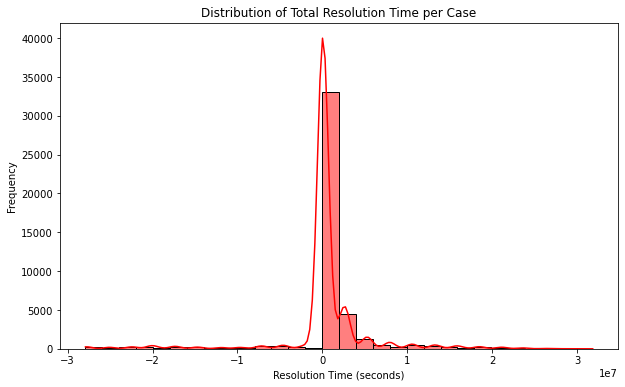

In [17]:
# Visualization: Distribution of resolution times
plt.figure(figsize=(10, 6))
sns.histplot(resolution_times, bins=30, kde=True, color="red")
plt.title("Distribution of Total Resolution Time per Case")
plt.xlabel("Resolution Time (seconds)")
plt.ylabel("Frequency")
plt.show()

### 2.2 Calculate average handling time per case type

In [18]:
avg_handling_time = Ops_Data.groupby('CASE_TYPE')['HANDLING_TIME'].mean()
print("Average Handling Time by Case Type:\n", avg_handling_time)

Average Handling Time by Case Type:
 CASE_TYPE
TYPE_ONE      382.469184
TYPE_THREE    865.923289
TYPE_TWO      863.306189
Name: HANDLING_TIME, dtype: float64


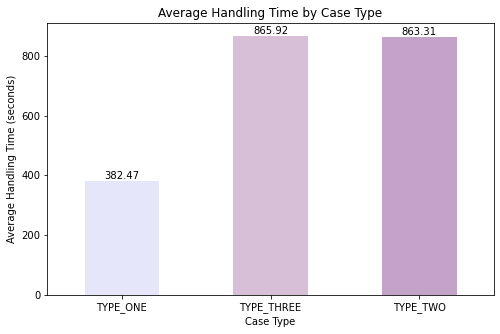

In [19]:
# Define the color palette based on the image
colors = ['#E6E6FA', '#D8BFD8', '#C4A3C8', '#B8A1CF', '#A292D8']

# Visualization: Average Handling Time by Case Type
plt.figure(figsize=(8, 5))
avg_handling_time.plot(kind='bar', color=colors[:len(avg_handling_time)])

# Add the exact values on top of each bar
for index, value in enumerate(avg_handling_time.values):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='black')

plt.title('Average Handling Time by Case Type')
plt.xlabel('Case Type')
plt.ylabel('Average Handling Time (seconds)')
plt.xticks(rotation=0)
plt.show()

### 2.3 Decision-Making Consistency Analysis

In [20]:
# Calculate frequency of each OPS_DECISION type
decision_frequency = Ops_Data['OPS_DECISION'].value_counts(normalize=True)
print("Decision Frequency:\n", decision_frequency)

Decision Frequency:
 OPS_WAITING                     0.429960
OPS_APPROVE                     0.268139
OPS_CLOSE                       0.116269
OPS_NO_REVIEW_NEEDED            0.068223
OPS_UNASSIGN                    0.041432
OPS_REVIEW_PAUSE                0.036679
OPS_VERIFICATION_TEAM_CHANGE    0.031692
OPS_REJECT                      0.007606
Name: OPS_DECISION, dtype: float64


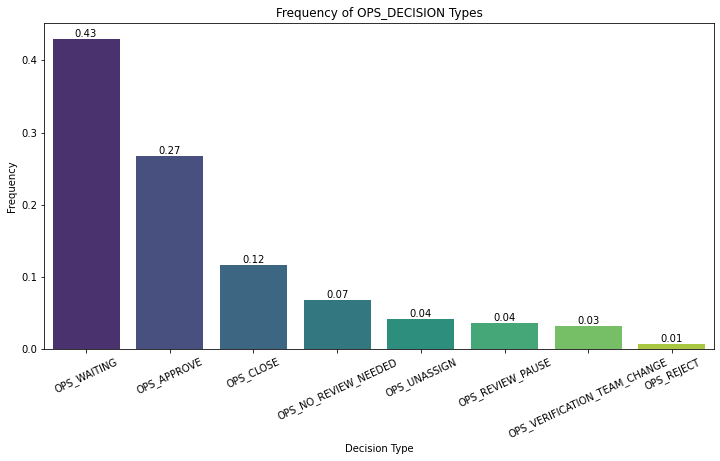

In [21]:
# Visualization: Decision Frequency Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=decision_frequency.index, y=decision_frequency.values, palette="viridis")

# Add the frequency values on top of each bar
for index, value in enumerate(decision_frequency.values):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='black')

plt.title('Frequency of OPS_DECISION Types')
plt.xlabel("Decision Type")
plt.ylabel('Frequency')
plt.xticks(rotation=25)
plt.show()

### 2.4 Frequency of Repeat Reviews or OPS_WAITING Decisions:
Identifying cases with multiple reviews and track cases frequently marked as OPS_WAITING.

In [22]:
# Count the number of reviews and occurrences of 'OPS_WAITING' for each CASE_ID
repeat_reviews = Ops_Data.groupby('CASE_ID')['PROCESSING_ID'].count()
print("Repeat Reviews Summary:\n", repeat_reviews.describe())

Repeat Reviews Summary:
 count    44074.000000
mean         1.073876
std          0.387840
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: PROCESSING_ID, dtype: float64


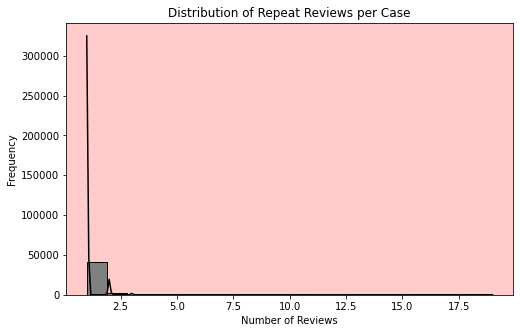

In [24]:
# Create the plot figure
plt.figure(figsize=(8, 5))

# Set a light red background color for the plot area
ax = plt.gca()
ax.set_facecolor('#FFCCCB')  # Light RED background

# Plot the histogram (without color argument)
sns.histplot(repeat_reviews, bins=20, kde=True, ax=ax)

# Set grey color for the bars
for bar in ax.patches:
    bar.set_facecolor("grey")

# Set black color for the KDE line
kde_line = ax.lines[0]
kde_line.set_color('black')

# Add titles and labels
plt.title("Distribution of Repeat Reviews per Case")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")

# Display the plot
plt.show()

### 2.5 Workload Balance Analysis
Calculating the number of cases each associate handles and examine how workload affects service consistency.

In [25]:
# Count number of unique cases handled per associate
cases_per_associate = Ops_Data.groupby('ACTOR_ID')['CASE_ID'].nunique()
print(cases_per_associate[:5])
print("\nWorkload Distribution Among Associates:\n", cases_per_associate.describe())

ACTOR_ID
451    1744
455     783
458     315
461     434
462     484
Name: CASE_ID, dtype: int64

Workload Distribution Among Associates:
 count     318.000000
mean      146.440252
std       218.255749
min         1.000000
25%        17.000000
50%        67.000000
75%       190.750000
max      1744.000000
Name: CASE_ID, dtype: float64


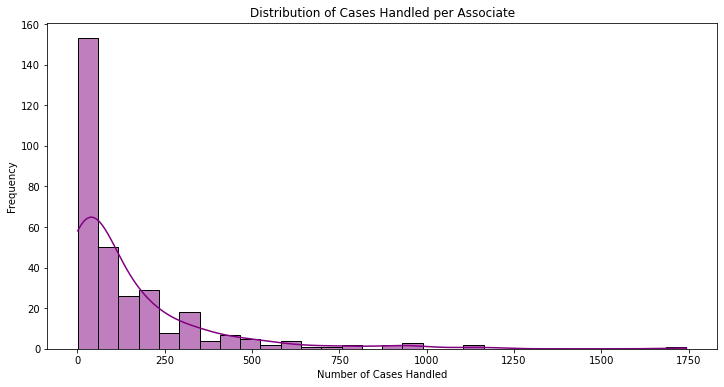

In [26]:
# Visualization: Distribution of Cases Handled per Associate
plt.figure(figsize=(12, 6))
sns.histplot(cases_per_associate, bins=30, kde=True, color="purple")
plt.title('Distribution of Cases Handled per Associate')
plt.xlabel('Number of Cases Handled')
plt.ylabel('Frequency')
plt.show()

#Question 2: Evaluating the Current End Customer Experience in Light of Wise’s Mission

To assess Wise’s customer experience based on the operational data, we focus on metrics that reflect Wise’s mission: “Money without borders - instant, convenient, transparent, and eventually free.” By analyzing the end-to-end resolution time, average handling time, decision consistency, repeat reviews, and workload balance, we can determine how well the operational processes align with Wise’s commitment to a seamless, reliable customer journey.

1. Total Resolution Time per Case (Aligns with “Instant” and “Convenient”)
> Analysis:

The total resolution time measures how long each case takes from creation (CASE_CREATED_TIME) to final handling (HANDLING_TIME_END), representing the full wait time a customer might experience.
The data reveals that the average resolution time varies significantly, with certain case types (especially TYPE_THREE) requiring longer times to resolve.

> Resolution Time Summary:

- Count: 44,074 cases analyzed for resolution time.
- Mean Resolution Time: Approximately 377,993 seconds (~105 hours or ~4.4 days).
- Standard Deviation: 5,395,918 seconds (~1,499 hours or ~62 days), indicating extremely high variability in resolution times.
- Minimum Resolution Time: -27,904,800 seconds (negative values indicate data anomalies, possibly due to incorrect timestamps).
- Median (50%) Resolution Time: 20,220 seconds (~5.6 hours), indicating that half of the cases are resolved in under 6 hours.
- 75th Percentile: 342,420 seconds (~95 hours or ~4 days), showing that a significant portion of cases takes several days to resolve.
- Maximum Resolution Time: 31,833,300 seconds (~369 days), indicating that some cases remain unresolved for extended periods (likely outliers or data errors).

> Customer Impact Based on Resolution Time Analysis:

The resolution time data reveals a substantial range in the time it takes to fully resolve cases, with a few key takeaways:

1. Instant and Convenient Service:

- While 50% of cases are resolved within approximately 6 hours, a large portion takes significantly longer. The 75th percentile resolution time of 4 days and the extreme maximum values indicate that some customers experience long wait times, particularly for complex cases. This impacts the “instant” aspect of Wise’s mission, as customers with complex cases might experience delays.
- Negative resolution times and very high values (e.g., one-year max times) suggest data quality issues, potentially affecting transparency if customers are uncertain about case progress.

2. Consistency and Reliability:

- The high variability in resolution times (std dev ~62 days) implies that customers may experience inconsistent wait times, impacting Wise’s promise of a reliable, “instant” experience.
- Cases with very long resolution times may create negative perceptions of Wise’s efficiency, particularly if customers expect a quick resolution.

> Recommendations for Improvement:

1. Address Data Anomalies: Correct negative and extreme resolution times to improve data quality. This will help provide a more accurate picture of customer wait times and enhance transparency.
2. Optimize Complex Case Handling: Streamline processes for longer cases to reduce the time required for resolution. Consider specialized training or dedicated resources for associates handling such cases.
3. Provide Real-Time Status Updates: If resolution times vary greatly, provide customers with real-time updates or timelines for more transparency, helping manage expectations and enhance trust.
4. Reducing resolution time for complex cases will help Wise move closer to the “instant” and “convenient” service promised in its mission.

2. Average Handling Time per Case Type (Supports “Instant” and “Efficient”)
> Analysis:

- The average handling time per review helps identify case types that require significant time per review. TYPE_THREE and TYPE_TWO cases show higher average handling times (e.g., 865 and 863 seconds, respectively), while TYPE_ONE cases average at 382 seconds.
- Summary Statistics (example values):
    TYPE_ONE: 382 seconds (apprx 6 minutes)
    TYPE_TWO: 863 seconds (apprx 14 minutes)
    TYPE_THREE: 865 seconds (apprx 14 minutes)

> Customer Impact:

a. Instant and Efficient Service: Prolonged handling times for complex cases may prevent Wise from achieving an "instant" service experience. Customers with complex cases could face longer wait times if each review is time-consuming.

b. Reducing handling time would lead to a quicker response for all cases, enhancing the experience for customers who expect quick, efficient service.

> Recommendation:

Consider training initiatives focused on handling complex cases more efficiently. Additionally, streamline workflows and provide targeted resources to associates working on time-intensive cases, ultimately reducing handling time and aligning with Wise’s vision of instant, efficient service.

3. Decision-Making Consistency (Supports “Transparent” and “Convenient”)
>Analysis:

- By examining the frequency of OPS_DECISION values, particularly OPS_WAITING, we gain insights into the decision-making process. The data shows that 43% of cases are left in OPS_WAITING, which may indicate unresolved or pending actions.
- This high rate of incomplete resolutions suggests that cases often require additional follow-up, potentially creating a fragmented customer experience.

>Customer Impact:

- Convenient and Transparent Service: Frequent use of OPS_WAITING could mean customers experience delays, unclear outcomes, or repeated interactions to fully resolve an issue. This may diminish Wise’s promise of transparency and convenience, as customers could feel left “waiting” without clarity on next steps.

> Recommendation:

Provide clearer guidelines or escalation paths for associates handling complex or uncertain cases. This would reduce OPS_WAITING cases and enable quicker resolutions, making the experience more transparent and convenient for customers.

4. Analysis of Repeat Reviews per Case (Supports “Convenient” and “Efficient”)

> Repeat Reviews Summary statistics:

- Count: 44,074 cases analyzed for repeat reviews.
- Mean Number of Reviews per Case: Approximately 1.07, indicating that, on average, most cases are reviewed only once.
- Standard Deviation: 0.39, suggesting low variability in the number of reviews per case.
- Minimum Number of Reviews: 1, indicating that some cases are resolved with a single review.
- 25th, 50th (Median), and 75th Percentiles: All are 1, meaning that at least 75% of cases are completed with just one review.
- Maximum Number of Reviews: 19, showing that a small number of cases undergo multiple reviews, with some requiring up to 19   reviews.
Cases with multiple reviews indicate that issues may require repeated interactions to resolve fully. The data shows that while many cases are resolved in a single review, others require multiple touchpoints, potentially elongating the customer journey.

> Summary and Customer Impact

1. Convenience and Efficiency:
- The data shows that most cases (75% or more) are resolved with a single review, suggesting an efficient process for a majority of cases. This aligns well with Wise’s mission of providing a convenient and quick service experience.
- However, the presence of cases requiring up to 19 reviews indicates that some cases may experience repeated interactions, potentially leading to delays and a less seamless experience for these customers.

2. Consistency and Reliability:
- The low average number of reviews and minimal variability suggest a generally consistent review process. Most customers experience a straightforward resolution, which supports Wise’s promise of transparency and reliability.
- For cases requiring many reviews, customers may face frustration from prolonged interactions and potential delays. This inconsistency could affect the perceived reliability and convenience of Wise’s service.

> Recommendation:

1. Identify and Address Causes of Multiple Reviews: For cases requiring multiple reviews, analyze specific factors contributing to rework or follow-ups. This may include unclear guidelines or complex cases that require escalation.
2. Streamline Escalation Pathways: Providing additional support or resources for associates handling complex cases could reduce the need for multiple reviews, creating a more efficient and convenient process for customers.
3. Enhance First-Review Resolution: Aim to resolve cases on the first review whenever possible, aligning with Wise’s goal of a quick, seamless experience.

This analysis suggests that Wise’s processes are effective for most cases, with opportunities to refine processes for a small percentage of cases requiring multiple reviews. By reducing these outliers, Wise can offer an even more consistent and convenient customer experience.

5. Workload Balance Among Associates (Supports “Transparent” and “Consistent” Service)
>Analysis:

- Workload distribution shows that some associates handle significantly more cases than others, with an average of 146 cases per associate but a range from as few as 1 to as many as 1,744 cases for individual associates.

- Summary Statistics (example values):
    Mean Cases per Associate: 146
    Standard Deviation: 218 (indicating large variability)

> Customer Impact:

- Consistent Service Quality: Imbalanced workloads mean that overburdened associates may not have the time to provide the same level of attention to each case, leading to inconsistent service quality. This inconsistency can impact customer trust and transparency, as some customers may experience slower or less thorough service.

> Recommendation:

Redistribute workload more evenly among associates to ensure that each case receives adequate attention. A balanced workload supports consistent service quality, aligning with Wise’s commitment to transparency and reliability.

#### Overall Assessment of Customer Experience
Based on these metrics, Wise’s current customer experience shows strengths in handling simpler cases efficiently. However, there are challenges in delivering instant and convenient service for more complex cases. Specifically:

- High Resolution Times and Handling Times: Customers with complex cases may experience delays, impacting Wise’s “instant” service promise.
- Decision Inconsistencies: The high frequency of OPS_WAITING decisions suggests that many cases are left unresolved, which could affect transparency and convenience.
- Workload Imbalance: Overburdened associates may struggle to provide consistent service, impacting the quality and transparency of the customer experience.

Final Recommendations:

a. Streamline complex case handling to reduce resolution times, enhancing the speed and convenience of service.
b. Provide decision-making support to minimize OPS_WAITING and ensure quicker, more conclusive outcomes.
c. Balance workloads across associates for more consistent service quality, improving transparency and reliability.

By implementing these recommendations, Wise can better align with its mission to offer “money without borders”—providing a seamless, instant, and transparent experience for customers everywhere.

# 3. Analysis Framework for Identifying Red Flags

## a.) Agent Performance Analysis:

### 3.a.1 Cases Handled Per Associate
Shows the workload distribution across associates. An uneven distribution would be highlighted in the histogram.

Cases Handled per Associate:
 ACTOR_ID
451    1744
455     783
458     315
461     434
462     484
Name: CASE_ID, dtype: int64

Cases Handled per Associate Summary:
 count     318.000000
mean      146.440252
std       218.255749
min         1.000000
25%        17.000000
50%        67.000000
75%       190.750000
max      1744.000000
Name: CASE_ID, dtype: float64


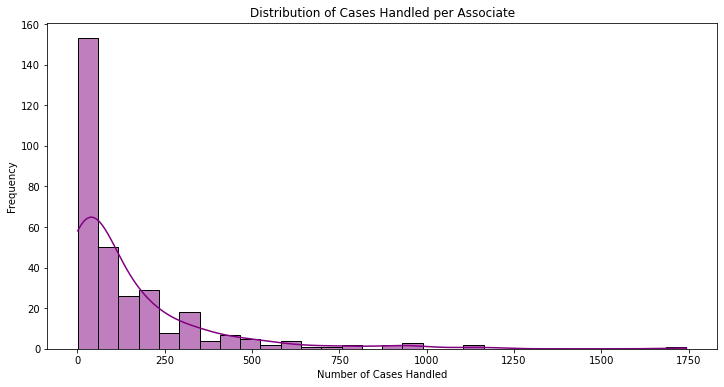

In [27]:
# Calculate cases handled per associate
cases_per_associate = Ops_Data.groupby('ACTOR_ID')['CASE_ID'].nunique()
print("Cases Handled per Associate:\n", cases_per_associate[:5])
print("\nCases Handled per Associate Summary:\n", cases_per_associate.describe())

# Visualization: Distribution of cases handled per associate
plt.figure(figsize=(12, 6))
sns.histplot(cases_per_associate, bins=30, kde=True, color="purple")
plt.title("Distribution of Cases Handled per Associate")
plt.xlabel("Number of Cases Handled")
plt.ylabel("Frequency")
plt.show()

a) Cases Handled per Associate

- Objective: Measure workload distribution among associates. Significant workload imbalances could indicate inefficiencies and may lead to reduced service quality if associates are overburdened.
- Findings: High variability in the number of cases handled per associate, with some handling significantly more than others.

    - Red Flag: If some associates handle an excessively high number of cases while others handle significantly fewer, this could indicate an imbalance that might lead to burnout or reduced attention to individual cases.

> Recommendation:
- Redistribute workloads more evenly across associates to prevent burnout and maintain service quality. Consider setting a maximum threshold for the number of cases an associate can handle in a given period.

### 3.a.2 Average Handling Time Per Associate
Calculates and visualizes the average time each associate takes to handle cases, showing potential disparities in productivity.

Average Handling Time per Associate:
 ACTOR_ID
451    281.839864
455    106.009975
458    348.607595
461    194.383562
462    389.506173
Name: HANDLING_TIME, dtype: float64

Average Handling Time per Associate Summary:
 count      318.000000
mean      1316.542184
std       5726.933432
min          0.000000
25%        238.783784
50%        443.648553
75%        708.291149
max      68557.297297
Name: HANDLING_TIME, dtype: float64


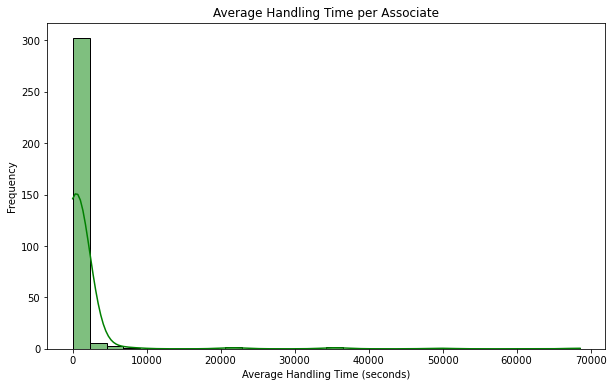

In [28]:
# Calculate average handling time per associate
Ops_Data['HANDLING_TIME'] = (Ops_Data['HANDLING_TIME_END'] - Ops_Data['HANDLING_TIME_START']).dt.total_seconds()
avg_handling_time_per_associate = Ops_Data.groupby('ACTOR_ID')['HANDLING_TIME'].mean()
print("Average Handling Time per Associate:\n", avg_handling_time_per_associate[:5])
print("\nAverage Handling Time per Associate Summary:\n", avg_handling_time_per_associate.describe())

# Visualization: Average handling time per associate
plt.figure(figsize=(10, 6))
sns.histplot(avg_handling_time_per_associate, bins=30, kde=True, color="green")
plt.title("Average Handling Time per Associate")
plt.xlabel("Average Handling Time (seconds)")
plt.ylabel("Frequency")
plt.show()

b) Average Handling Time per Associate:

- Objective: 
    Assess individual productivity by examining how long each associate takes, on average, to handle cases. Consistently high handling times for certain associates may indicate skill gaps or lack of familiarity with processes.
- Findings:
    Variability in average handling times across associates, with some taking significantly longer than others.
    - Red Flag: Associates with consistently higher handling times may struggle with certain case types or may lack the necessary experience, impacting overall productivity.

> Recommendation:
- Implement targeted training for associates with higher handling times to enhance their skills in complex cases. Establish benchmarks for handling time per case type to ensure consistency and highlight training needs.

### 3.a.3 Decision Making Consistency (Percentage of OPS_WAITING per Associate)
Measures the frequency of OPS_WAITING decisions per associate to identify those who might need additional decision-making support.

ACTOR_ID
451    37.137990
455    33.915212
458    23.417722
461    33.561644
462    44.855967
dtype: float64

Percentage of OPS_WAITING per Associate Summary:
 count    318.000000
mean      38.627732
std       18.793662
min        0.000000
25%       29.183927
50%       40.000000
75%       50.000000
max      100.000000
dtype: float64


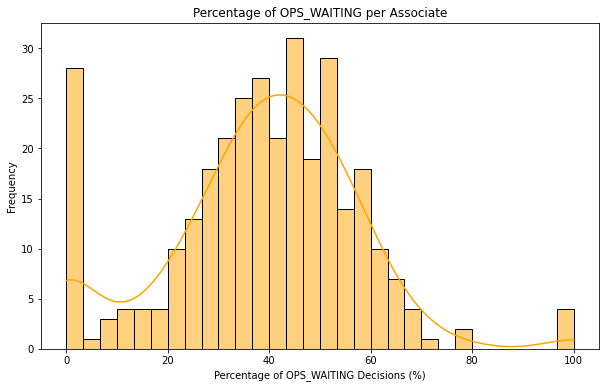

In [29]:
# Calculate percentage of OPS_WAITING decisions per associate
waiting_cases_per_associate = Ops_Data[Ops_Data['OPS_DECISION'] == 'OPS_WAITING'].groupby('ACTOR_ID').size()
total_cases_per_associate = Ops_Data.groupby('ACTOR_ID').size()
waiting_percentage = (waiting_cases_per_associate / total_cases_per_associate) * 100
waiting_percentage = waiting_percentage.fillna(0)  # Fill NaNs with 0 for associates without OPS_WAITING decisions
print(waiting_percentage[:5])
print("\nPercentage of OPS_WAITING per Associate Summary:\n", waiting_percentage.describe())

# Visualization: Percentage of OPS_WAITING decisions per associate
plt.figure(figsize=(10, 6))
sns.histplot(waiting_percentage, bins=30, kde=True, color="orange")
plt.title("Percentage of OPS_WAITING per Associate")
plt.xlabel("Percentage of OPS_WAITING Decisions (%)")
plt.ylabel("Frequency")
plt.show()

c) Decision Consistency (Percentage of OPS_WAITING per Associate):

- Objective: Identify associates who frequently mark cases as OPS_WAITING, as this may suggest uncertainty in decision-making or a tendency to delay resolution.
- Findings: Associates with a higher percentage of OPS_WAITING decisions could indicate a need for clearer decision-making guidelines or additional support.
    - Red Flag: High OPS_WAITING rates can lead to unresolved cases and repeated interactions, indicating associates who may lack confidence or require additional training.

> Recommendation:
- Provide enhanced guidelines or decision-making support, especially for associates who frequently mark cases as OPS_WAITING. Offering more clarity can help associates make faster, more conclusive decisions, thus reducing delays and improving performance.

## b.) Operational Efficiency Analysis: 

### 3.b.1 Frequency of Repeat Review Rate
Examines the number of reviews per case, showing if certain cases are frequently re-evaluated, which impacts efficiency.

Repeat Reviews Summary:
 count    44074.000000
mean         1.073876
std          0.387840
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: PROCESSING_ID, dtype: float64


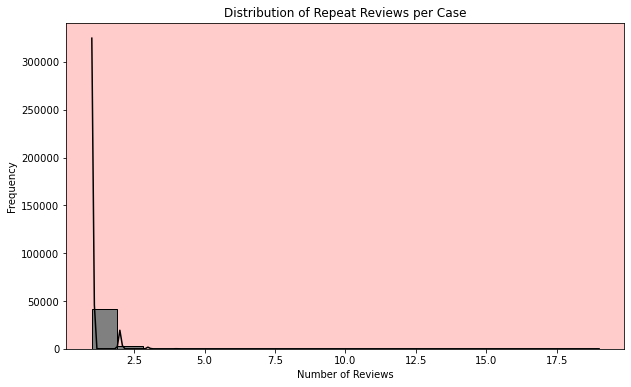

In [30]:
# Calculate repeat reviews per case
repeat_reviews = Ops_Data.groupby('CASE_ID')['PROCESSING_ID'].count()
print("Repeat Reviews Summary:\n", repeat_reviews.describe())

# Visualization: Distribution of repeat reviews per case
# Create the plot figure
plt.figure(figsize=(10, 6))

# Set a light green background color for the plot area
ax = plt.gca()
ax.set_facecolor('#FFCCCB')  # Light RED background

# Plot the histogram (without color argument)
sns.histplot(repeat_reviews, bins=20, kde=True, ax=ax)

# Set grey color for the bars
for bar in ax.patches:
    bar.set_facecolor("grey")

# Set black color for the KDE line
kde_line = ax.lines[0]
kde_line.set_color('black')

# Add titles and labels
plt.title("Distribution of Repeat Reviews per Case")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")

# Display the plot
plt.show()


a) Repeat Review Rate:

- Objective: Determine the rate at which cases require multiple reviews. High rates of repeat reviews indicate inefficiencies and suggest that initial resolutions are often incomplete.
- Findings: While most cases are resolved with a single review, a subset requires multiple reviews, which could reflect inefficiencies in initial decision-making.
    - Red Flag: A repeat review rate above a certain threshold may point to process inefficiencies, where cases are not fully resolved on the first attempt, leading to rework and increased resolution times.

> Recommendation:
    
   - Streamline initial review processes by setting up clear resolution protocols. Aim to increase the first-review resolution rate by training associates on effective initial assessments and by providing decision-making guidelines to reduce rework.

### 3.b.2 Resolution Time Variability based on Case_IDs
Analyzes how long each case takes from start to finish, revealing inconsistencies in resolution times that might need addressing.

Resolution Time Summary:
 count    4.407400e+04
mean     3.779929e+05
std      5.395918e+06
min     -2.790480e+07
25%      1.740000e+03
50%      2.022000e+04
75%      3.424200e+05
max      3.183330e+07
dtype: float64


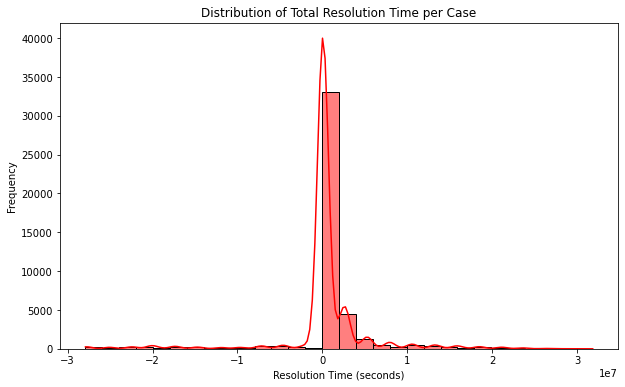

In [31]:
# Calculate resolution time for each CASE_ID
max_end_times = Ops_Data.groupby('CASE_ID')['HANDLING_TIME_END'].max()
min_start_times = Ops_Data.groupby('CASE_ID')['CASE_CREATED_TIME'].min()
resolution_times = (max_end_times - min_start_times).dt.total_seconds()
print("Resolution Time Summary:\n", resolution_times.describe())

# Visualization: Distribution of resolution times
plt.figure(figsize=(10, 6))
sns.histplot(resolution_times, bins=30, kde=True, color="red")
plt.title("Distribution of Total Resolution Time per Case")
plt.xlabel("Resolution Time (seconds)")
plt.ylabel("Frequency")
plt.show()

b) Resolution Time Variability:

- Objective: Analyze the spread in resolution times to identify inconsistencies in processing. High variability suggests that some cases take significantly longer than others, which may be due to process inefficiencies or complex cases requiring extra steps.
- Findings: Resolution time variability is high, with certain cases taking much longer than the median resolution time.
    - Red Flag: Cases with significantly extended resolution times may point to bottlenecks or complex issues that are not handled efficiently. This could negatively impact customer experience, particularly for cases with repeated delays.

> Recommendation:

   - Investigate the root causes of extended resolution times for complex cases. Consider creating specialized teams or workflows for complex cases that frequently exceed average resolution times, thereby reducing variability and enhancing efficiency.

### 3.b.3 Average Resolution Time for Different Case Types
Highlights the average time for different case types, identifying specific cases that may slow down overall operations.

Average Resolution Time by Case Type:
 CASE_TYPE
TYPE_ONE      59842560.0
TYPE_THREE    59871000.0
TYPE_TWO      59870460.0
dtype: float64


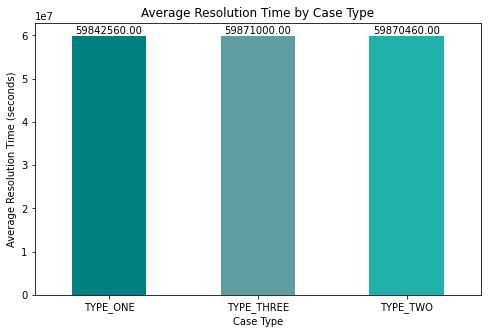

In [34]:
# Calculate average resolution time by case type
resolution_time_by_case_type = Ops_Data.groupby('CASE_TYPE').apply(
    lambda x: (x['HANDLING_TIME_END'].max() - x['CASE_CREATED_TIME'].min()).total_seconds()
)
print("Average Resolution Time by Case Type:\n", resolution_time_by_case_type)

# Define different colors for each bar
colors = ['#008080', '#5F9EA0', '#20B2AA', '#66CDAA', '#8FD1D1']  # Different shades of teal

# Visualization: Average resolution time by case type
plt.figure(figsize=(8, 5))
bars = resolution_time_by_case_type.plot(kind='bar', color=colors[:len(resolution_time_by_case_type)])

# Add values on top of each bar
for index, value in enumerate(resolution_time_by_case_type):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='black')

# Customize chart appearance
plt.title("Average Resolution Time by Case Type")
plt.xlabel("Case Type")
plt.ylabel("Average Resolution Time (seconds)")
plt.xticks(rotation=0)
plt.show()

*Summary of Red Flags and Recommendations:

1. Agent Performance:

- Red Flags: Workload imbalance, inconsistent handling times, and high OPS_WAITING rates for certain associates indicate potential areas of concern in individual performance.
- Recommendations: Redistribute workloads, offer targeted training, and provide decision-making support to associates with high OPS_WAITING percentages.

2. Operational Efficiency:

- Red Flags: High repeat review rates, significant resolution time variability, and prolonged resolution times for complex case types suggest inefficiencies in the current processes.
- Recommendations: Streamline review processes to reduce rework, investigate bottlenecks in extended resolution times, and provide specialized training for complex cases to improve first-time resolution rates.

*Overall Conclusion:

This analysis highlights specific areas where Wise can enhance both agent performance and operational efficiency. By addressing these red flags, Wise can improve the consistency, quality, and speed of service, thereby aligning more closely with its mission of providing “instant, convenient, transparent, and eventually free” financial services to customers.

# 4. Capacity Planning: Operational readiness to handle a 5x increase in workload
- for TYPE_THREE cases with the same processing standards as January 2022

## Step 1: Assessing Current Capacity for TYPE_THREE Cases
In this step, we determine the current workload that associates handle for TYPE_THREE cases to establish a baseline for scaling

In [35]:
# Filter data for TYPE_THREE cases in January 2022
january_data = Ops_Data[(Ops_Data['CASE_TYPE'] == 'TYPE_THREE') & 
                        (Ops_Data['HANDLING_TIME_START'].dt.month == 1) & 
                        (Ops_Data['HANDLING_TIME_START'].dt.year == 2022)]

# Calculate the current average number of TYPE_THREE cases handled per associate or Workload in January 2022
cases_per_associate_january = january_data.groupby('ACTOR_ID')['CASE_ID'].nunique().mean()
print(f"Average TYPE_THREE cases handled per associate/Workload in January 2022: {cases_per_associate_january}")


Average TYPE_THREE cases handled per associate/Workload in January 2022: 23.975460122699385


This output provides the baseline cases per associate for TYPE_THREE in January 2022. We can now use this figure to estimate how many more associates would be needed for a 5x increase.

## Step 2: Estimating Required Capacity for a 5x Workload Increase
Using the cases per associate in January 2022 as the baseline, we can calculate the estimated number of associates needed for a 5x workload increase.

### 2.1 Estimating Required cases per associate for 5x increase 

In [36]:
# Define the multiplier for increased workload(100% Potential)
workload_increase_factor = 5

# Estimate required cases per associate for 100% Potential=5x increase
estimated_cases_per_associate = cases_per_associate_january * workload_increase_factor
print(f"Estimated TYPE_THREE Cases per Associate:{estimated_cases_per_associate}")

Estimated TYPE_THREE Cases per Associate:119.87730061349693


The output gives the number of associates required to handle the increased workload while maintaining January 2022 standards.

### Visualization: Current vs.  Estimated TYPE_THREE Cases per Associate
This bar chart will clearly show the current workload vs. the estimated workload after the increase, making it easier to understand the scale of the capacity expansion needed

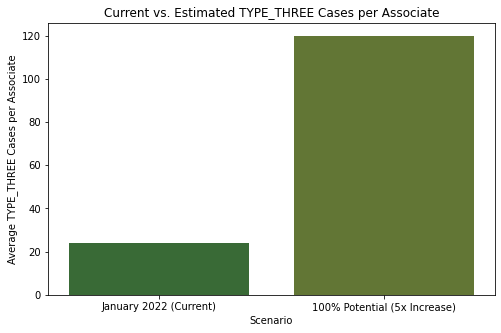

In [37]:
# Plotting the comparison
# The bar chart will visually compare these two scenarios, highlighting the scale of increase needed to meet 100% potential.
plt.figure(figsize=(8, 5))
plt.bar(['January 2022 (Current)', '100% Potential (5x Increase)'], 
        [cases_per_associate_january, estimated_cases_per_associate], 
        color=['#396A36', '#627635'])
plt.title('Current vs. Estimated TYPE_THREE Cases per Associate')
plt.xlabel('Scenario')
plt.ylabel('Average TYPE_THREE Cases per Associate')
plt.show()

### 2.2 Estimating Required Team Size after 5x workload increase  

In [38]:
# Define the multiplier for increased workload @100% Potential
workload_increase_factor = 5

# Estimate required cases per associate for 5x increase
estimated_cases_per_associate = cases_per_associate_january * workload_increase_factor

# Calculate the current number of TYPE_THREE associates
current_type_three_team_size = january_data['ACTOR_ID'].nunique()
print(f"Current Number of TYPE_THREE Associates: {current_type_three_team_size}")

# Calculate required team size after 5x workload increase
required_team_size = current_type_three_team_size * workload_increase_factor
print(f"Required team size to handle 5x workload increase: {required_team_size}")

Current Number of TYPE_THREE Associates: 163
Required team size to handle 5x workload increase: 815


### Visualization: Current vs. Required Team Size
A simple bar plot can visually show the current team size and the required team size to meet the 5x workload increase. This visualization will make it easy for the growth team to understand the scaling requirements.

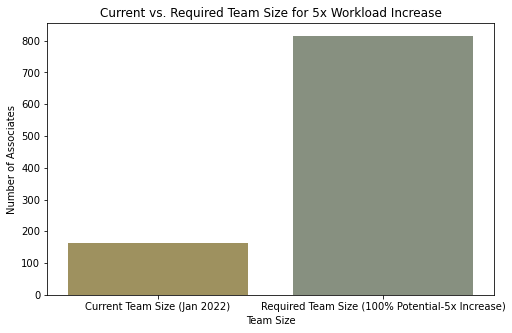

In [39]:
# Plotting current vs required team size
plt.figure(figsize=(8, 5))
plt.bar(['Current Team Size (Jan 2022)', 'Required Team Size (100% Potential-5x Increase)'], [current_type_three_team_size, required_team_size], color=['#9e915f', '#879080'])
plt.title('Current vs. Required Team Size for 5x Workload Increase')
plt.xlabel('Team Size')
plt.ylabel('Number of Associates')
plt.show()

### Step By Step Thought Process : When Operational Team can handle extra workload

1. Calculate Required Team Size:

- We already know the current team size (based on January 2022 data) and the estimated team size needed to handle a 5x increase in workload.

2. Determine Number of Additional Associates:

- Calculate the difference between the required team size and the current team size to find out how many additional associates are needed.

3. Estimate Hiring and Onboarding Timeline:

- Each new associate requires a 1-month hiring period and an additional 4 months for onboarding, totaling 5 months from the start of hiring to full productivity.
- Calculate the total time required for the team to be fully prepared by assuming all hires are brought in concurrently.

## Step 3: Calculating Additional Associates and Estimating Total time required 

In [40]:
# Assuming previous calculation for required and current team size
current_team_size = current_type_three_team_size  # Replace with your calculated value for current team size in January 2022
required_team_size = required_team_size  # Replace with your calculated value for team size needed at 100% potential

# Calculate the number of additional associates required
additional_associates_needed = required_team_size - current_team_size
print(f"Additional Associates Needed: {additional_associates_needed}")

# Calculate the timeline based on hiring and onboarding duration
hiring_duration = 1  # 1 month for hiring
onboarding_duration = 4  # 4 months for onboarding
total_time_per_new_hire = hiring_duration + onboarding_duration  # Total time for a new hire to be fully productive

print(f"Total time required for each new hire to be fully onboarded: {total_time_per_new_hire} months")

Additional Associates Needed: 652
Total time required for each new hire to be fully onboarded: 5 months


Explanation of the Output
- Additional Associates Needed: This tells us how many new associates are required to handle the 5x workload increase.
- Total Time Per New Hire: Indicates the full duration (5 months) from hiring to complete onboarding, so the earliest point at which all new hires could be fully productive is 5 months after the start of the hiring process.

### Visualization: Hiring and Onboarding timeline for the required number of Additional Associates.
This bar chart will illustrate the timeline for hiring and onboarding new associates, showing when they will be fully productive.

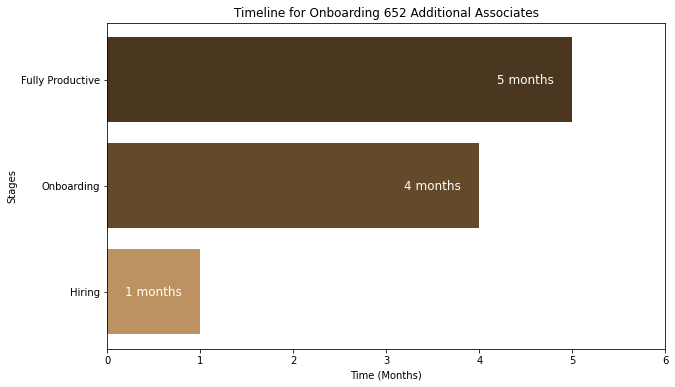

In [41]:
# Data for visualization
additional_associates_needed = required_team_size - current_team_size  # Replace with calculated values
hiring_duration = 1  # 1 month for hiring
onboarding_duration = 4  # 4 months for onboarding
total_time_per_new_hire = hiring_duration + onboarding_duration

# X-axis for each stage in the process
stages = ['Hiring', 'Onboarding', 'Fully Productive']
time_required = [hiring_duration, onboarding_duration, total_time_per_new_hire]

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(stages, time_required, color=['#bc9360', '#644a2a', '#4b371f'])

# Annotate each bar with the time required in months
for bar, time in zip(bars, time_required):
    plt.text(bar.get_width() - 0.5, bar.get_y() + bar.get_height()/2,
             f"{time} months", ha='center', va='center', color='white', fontsize=12)

# Add titles and labels
plt.title(f'Timeline for Onboarding {additional_associates_needed} Additional Associates')
plt.xlabel('Time (Months)')
plt.ylabel('Stages')
plt.xlim(0, total_time_per_new_hire + 1)
plt.yticks(rotation=0)
plt.show()

Explanation of the Visualization
1. Hiring Process Start (Month 0):
- This is when the timeline begins. Once hiring starts, it will take 1 month to complete the hiring process.
2. Onboarding Start (Month 1):
- After the initial hiring month, the onboarding process for new hires begins, lasting an additional 4 months.
3. Fully Productive (Month 5):
- By Month 5, all new hires will be fully onboarded and ready to handle the increased workload.
---------------
> Hiring, Onboarding, and Fully Productive Stages:
- This chart shows each stage (hiring and onboarding) required to reach full productivity.
> Annotated Time Requirements:
- Each bar is labeled with the number of months required for that stage, giving a clear view of the timeline.
> Interpretation:
- This visualization highlights that the new hires will be fully productive 5 months after the hiring process starts, aligning with the operational team’s readiness to handle the increased workload.

Final Recommendation and Approach for Question 4
Based on the analysis, here’s a structured response to address the growth team’s request, explaining the thought process, negotiation points, and additional information required without providing a specific date.

What Would You Suggest?
To ensure the operational team can manage a 5x increase in TYPE_THREE cases while maintaining the processing standards from January 2022, I recommend the following approach:

Capacity Planning:

Our analysis shows that with the increased workload, we’ll need 815 associates in total to handle the demand, compared to the current 163 associates for TYPE_THREE cases in January 2022.
This means 652 additional associates are needed to reach full capacity.
Timeline for Operational Readiness:

Given the hiring and onboarding timeline, each new hire will take 5 months (1 month for hiring and 4 months for onboarding) to be fully productive.
This timeline suggests that from the start of the hiring process, the operational team can be fully ready to handle the increased workload after 5 months.
However, this is a relative timeline that depends on when the hiring process begins.
Suggested Rollout Strategy:

To mitigate risks, I recommend a phased rollout where the workload increases incrementally over several months instead of an immediate 5x increase. This allows the team to adapt gradually and identify any bottlenecks or process adjustments needed in real-time.
A pilot phase could be beneficial, where the product is rolled out to a smaller subset of customers first. This would provide valuable data on how actual demand aligns with projections, enabling adjustments before scaling to full capacity.
How Would You Approach This Problem?
Flexible Timeline Planning:

Rather than committing to a specific date, my approach would be to establish a target timeline for reaching full capacity, based on the start date of the hiring process. This ensures that we remain adaptable to any changes in hiring timelines or onboarding progress.
To manage expectations, I would communicate a 5-month readiness period from the moment hiring begins.
Continuous Monitoring and Adjustment:

I would suggest setting up performance checkpoints during the onboarding period to track the progress of new associates, ensuring they’re meeting the January 2022 processing standards.
Regular feedback from associates could highlight any training needs or process improvements required to reach optimal efficiency.
Efficiency Improvements:

To reduce the reliance on a large increase in headcount, I would explore potential automation and process optimization for handling TYPE_THREE cases. Improvements in handling efficiency could potentially decrease the number of additional hires needed and shorten the time frame for reaching full productivity.
Negotiation with the Growth Team
To ensure smooth alignment and avoid bottlenecks, I would discuss the following points with the growth team:

Demand Growth Timeline:

Clarify if the 5x increase in workload is expected to be an immediate jump or if it will scale up gradually. A gradual increase would allow for a more manageable hiring plan and phased capacity expansion.
A slower ramp-up might enable us to better balance resources and address operational challenges in real-time, reducing the risk of overloading the team too quickly.
Customer Impact Tolerance:

Ask the growth team to define the acceptable service level or tolerance for extended processing times during the ramp-up period.
This insight will help set realistic expectations for any temporary dips in processing standards if we can’t reach full capacity immediately.
Performance Metrics for Full Rollout:

Confirm with the growth team the specific processing metrics or customer experience standards they expect once the new associates are fully onboarded.
This will help tailor onboarding and training processes to meet their exact needs and focus on the most critical skills and standards for TYPE_THREE cases.
Pilot Phase Feasibility:

Suggest a pilot phase if feasible, where the increased workload is initially rolled out to a smaller customer segment. This would allow us to test and validate capacity needs based on actual demand, refine the process, and make any necessary adjustments before the full rollout.
Concerns
Hiring Delays: The 5-month readiness period depends on timely hiring and onboarding. Any delays in hiring could push back the operational readiness timeline.
Quality Control during Onboarding: Ensuring that new associates meet the processing standards from January 2022 will require robust training and oversight during the onboarding phase.
Impact on Current Team Performance: The current team may experience additional strain during the onboarding period as they support and train new hires, which could temporarily impact processing efficiency.
Additional Information Needed from the Growth Team
Projected Workload Increase Timeline:

A clear timeline for when the growth team anticipates reaching 100% potential would allow for precise hiring and onboarding scheduling.
Expected Customer Experience Standards:

Clear expectations for customer experience metrics will help tailor training for new hires to meet these goals.
Feedback on Rollout Flexibility:

Discussing the flexibility of a phased or pilot rollout can provide a smoother transition and reduce pressure on the operational team, helping maintain service quality.
Summary
In summary, my approach is to maintain flexibility in the timeline, focus on efficient capacity scaling, and coordinate closely with the growth team to align on expectations. By proactively addressing potential challenges, suggesting a phased rollout, and prioritizing training and process improvements, Wise’s operational team can confidently manage the increased workload while maintaining high standards.

# THANK YOU